In [1]:
import os

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook
from datetime import datetime, timedelta

import warnings

warnings.filterwarnings('ignore')

In [2]:
RAND = 123

Данные взяты из kaggle https://www.kaggle.com/competitions/nyc-taxi-trip-duration

In [3]:
df = pd.read_csv("train.csv")
weather = pd.read_csv("weather.csv")
routes_1 = pd.read_csv('fastest_routes_train_part_1.csv')
routes_2 = pd.read_csv('fastest_routes_train_part_2.csv')
routes = routes_1.append(routes_2)

In [4]:
print(f'data_shape={df.shape}')
print(f'weather_shape={weather.shape}')
print(f'routes_shape={routes.shape}')

data_shape=(1458644, 11)
weather_shape=(366, 7)
routes_shape=(1458643, 12)


## Data description

- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor ---because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds

In [5]:
df.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


In [6]:
routes.head(3)

,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id2875421,Columbus Circle,East 65th Street,2009.1,164.9,5,Columbus Circle|Central Park West|65th Street ...,0|576.4|885.6|547.1|0,0|61.1|60.1|43.7|0,depart|rotary|turn|new name|arrive,left|straight|right|straight|arrive,"-73.982316,40.767869|-73.981997,40.767688|-73...."
1,id2377394,2nd Avenue,Washington Square West,2513.2,332.0,6,2nd Avenue|East 13th Street|5th Avenue|Washing...,877.3|836.5|496.1|164.2|139.1|0,111.7|109|69.9|25.8|15.6|0,depart|turn|turn|end of road|continue|arrive,none|right|left|right|left|arrive,"-73.980429,40.73857|-73.985444,40.731658|-73.9..."
2,id3504673,Greenwich Street,Broadway,1779.4,235.8,4,Greenwich Street|Park Place|Broadway|Broadway,644.2|379.9|755.3|0,80.5|50.8|104.5|0,depart|turn|end of road|arrive,left|left|right|arrive,"-74.010145,40.719982|-74.011527,40.714294|-74...."


In [7]:
weather.head(3)

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,1-1-2016,42,34,38.0,0.00,0.0,0
1,2-1-2016,40,32,36.0,0.00,0.0,0
2,3-1-2016,45,35,40.0,0.00,0.0,0


Пропуски в данных отсутсвуют

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [9]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 366 non-null    object 
 1   maximum temperature  366 non-null    int64  
 2   minimum temperature  366 non-null    int64  
 3   average temperature  366 non-null    float64
 4   precipitation        366 non-null    object 
 5   snow fall            366 non-null    object 
 6   snow depth           366 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 20.1+ KB


In [10]:
routes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458643 entries, 0 to 758642
Data columns (total 12 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1458643 non-null  object 
 1   starting_street       1458643 non-null  object 
 2   end_street            1458643 non-null  object 
 3   total_distance        1458643 non-null  float64
 4   total_travel_time     1458643 non-null  float64
 5   number_of_steps       1458643 non-null  int64  
 6   street_for_each_step  1458643 non-null  object 
 7   distance_per_step     1458643 non-null  object 
 8   travel_time_per_step  1458643 non-null  object 
 9   step_maneuvers        1458643 non-null  object 
 10  step_direction        1458643 non-null  object 
 11  step_location_list    1458643 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 144.7+ MB


## EDA и Featute engineering

Проверяем, что все id уникальны

In [11]:
print(df.id.nunique() == df.shape[0])
print(routes.id.nunique() == routes.shape[0])

True
True


In [12]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Заметим, что в данных есть выбросы. Есть поездки с 0 пассажирами, а так же поездки вне Нью-Йорка. Более того есть поездки длиной в 1 секунду и 20 часов. 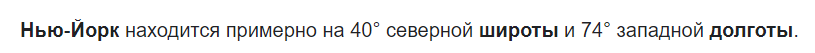

In [13]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.00000,1458644.00000,1458644.00000,1458644.00000,1458644.00000,1458644.00000,1458644.00000
mean,1.53495,1.66453,-73.97349,40.75092,-73.97342,40.75180,959.49227
std,0.49878,1.31424,0.07090,0.03288,0.07064,0.03589,5237.43172
min,1.00000,0.00000,-121.93334,34.35970,-121.93330,32.18114,1.00000
25%,1.00000,1.00000,-73.99187,40.73735,-73.99133,40.73588,397.00000
50%,2.00000,1.00000,-73.98174,40.75410,-73.97975,40.75452,662.00000
75%,2.00000,2.00000,-73.96733,40.76836,-73.96301,40.76981,1075.00000
max,2.00000,9.00000,-61.33553,51.88108,-61.33553,43.92103,3526282.00000


Удалим часть выбросов

In [14]:
print(df['passenger_count'].unique())

[1 6 4 2 3 5 0 7 9 8]


In [15]:
df = df[df.pickup_longitude.between(-75, -71) & df.dropoff_longitude.between(-75, -71)]
df = df[~df.passenger_count.isin([0])]

In [16]:
m = np.mean(df['trip_duration'])
s = np.std(df['trip_duration'])
df = df[df['trip_duration'] <= m + 2*s]
df = df[df['trip_duration'] >= m - 2*s]

In [17]:
df.shape

(1456451, 11)

А так же преобразуем формат даты и создадим новые колонки про дату, месяц, день и т.п. отдельно

In [18]:
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)

df.loc[:, 'date'] = df['pickup_datetime'].dt.date

df.loc[:, 'pickup_month'] = df['pickup_datetime'].dt.month

df.loc[:, 'pickup_day'] = df['pickup_datetime'].dt.day

df.loc[:, 'pickup_dayofweek'] = df['pickup_datetime'].dt.dayofweek

df.loc[:, 'pickup_hour'] = df['pickup_datetime'].dt.hour
df.loc[:, 'pickup_minute'] = df['pickup_datetime'].dt.minute

df.loc[:, 'store_and_fwd_flag'] = 1 * (df.store_and_fwd_flag.values == 'Y')

In [19]:
df.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,date,pickup_month,pickup_day,pickup_dayofweek,pickup_hour,pickup_minute
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98215,40.76794,-73.96463,40.76560,0,455,2016-03-14,3,14,0,17,24
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98042,40.73856,-73.99948,40.73115,0,663,2016-06-12,6,12,6,0,43


In [20]:
weather.describe()

,maximum temperature,minimum temperature,average temperature
count,366.00000,366.00000,366.00000
mean,64.62568,49.80601,57.21585
std,18.04179,16.57075,17.12476
min,15.00000,-1.00000,7.00000
25%,50.00000,37.25000,44.00000
50%,64.50000,48.00000,55.75000
75%,81.00000,65.00000,73.50000
max,96.00000,81.00000,88.50000


In [21]:
weather.describe(include='object')

,date,precipitation,snow fall,snow depth
count,366,366,366,366
unique,366,63,11,10
top,1-1-2016,0,0,0
freq,1,116,179,346


In [22]:
weather.precipitation.unique()

array(['0.00', 'T', '1.80', '0.24', '0.05', '0.01', '2.31', '0.73',
       '0.53', '0.44', '1.01', '0.03', '0.30', '1.22', '0.02', '0.14',
       '0.11', '0.06', '0.29', '0.07', '0.04', '0.38', '0.16', '0.09',
       '0.47', '0.20', '0.61', '0.54', '0.25', '0.18', '1.65', '0.40',
       '0.91', '0.45', '0.22', '0.12', '0.83', '0', '0.49', '0.66',
       '0.08', '0.62', '0.35', '1', '1.09', '1.08', '0.15', '0.32',
       '0.82', '0.31', '0.5', '0.56', '0.68', '0.2', '0.4', '0.23',
       '0.55', '1.11', '1.41', '1.81', '2.2', '0.19', '0.39'],
      dtype=object)

In [23]:
weather['snow fall'].unique()

array(['0.0', 'T', '0.4', '0.2', '27.3', '2.5', '0.1', '1.4', '0.5', '0',
       '2.8'], dtype=object)

In [24]:
weather['snow depth'].unique()

array(['0', 'T', '6', '22', '19', '17', '9', '4', '2', '1'], dtype=object)

T в уникальныз значениях означает, что не хватило данных для измерения, поэтому заменим на нулевое значение

In [25]:
weather.loc[weather['precipitation'] == 'T', 'precipitation'] = '0.00'
weather['precipitation'] = weather['precipitation'].astype(float)

weather.loc[weather['snow fall'] == 'T', 'snow fall'] = '0.00'
weather['snow fall'] = weather['snow fall'].astype(float)

weather.loc[weather['snow depth'] == 'T', 'snow depth'] = '0.00'
weather['snow depth'] = weather['snow depth'].astype(float)

И наконец соединим данные о погоде с информациоей о поездке

In [26]:
weather.loc[:, 'date'] = weather.date.apply(lambda x: datetime.strptime(x, '%d-%m-%Y'))
weather.loc[:, 'date'] = weather['date'].dt.date

In [27]:
data = pd.merge(df, weather, how='left', on='date')

In [28]:
data.isna().sum()

id                     0
vendor_id              0
pickup_datetime        0
dropoff_datetime       0
passenger_count        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude      0
dropoff_latitude       0
store_and_fwd_flag     0
trip_duration          0
date                   0
pickup_month           0
pickup_day             0
pickup_dayofweek       0
pickup_hour            0
pickup_minute          0
maximum temperature    0
minimum temperature    0
average temperature    0
precipitation          0
snow fall              0
snow depth             0
dtype: int64

In [29]:
data.reset_index(drop=True, inplace=True)

И так же добавим пройденное расстояние

In [30]:
data = pd.merge(data, routes[['id', 'total_distance']], on='id', how='left')

In [31]:
data.isna().sum()

id                     0
vendor_id              0
pickup_datetime        0
dropoff_datetime       0
passenger_count        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude      0
dropoff_latitude       0
store_and_fwd_flag     0
trip_duration          0
date                   0
pickup_month           0
pickup_day             0
pickup_dayofweek       0
pickup_hour            0
pickup_minute          0
maximum temperature    0
minimum temperature    0
average temperature    0
precipitation          0
snow fall              0
snow depth             0
total_distance         1
dtype: int64

In [32]:
m = data.total_distance.mean()
data.total_distance = data.total_distance.fillna(m)

In [33]:
data.isna().sum()

id                     0
vendor_id              0
pickup_datetime        0
dropoff_datetime       0
passenger_count        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude      0
dropoff_latitude       0
store_and_fwd_flag     0
trip_duration          0
date                   0
pickup_month           0
pickup_day             0
pickup_dayofweek       0
pickup_hour            0
pickup_minute          0
maximum temperature    0
minimum temperature    0
average temperature    0
precipitation          0
snow fall              0
snow depth             0
total_distance         0
dtype: int64

Добавим дополнительный признак, обозначающий пройденное расстояние между двумя точками Земли по формула гаверсинуса

In [34]:
from math import radians, cos, sin, asin, sqrt


def haversine(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [35]:
data['distance_haversine'] = haversine(data['pickup_latitude'].values, data['pickup_longitude'].values, data['dropoff_latitude'].values, data['dropoff_longitude'].values)

In [36]:
data.head(1)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_minute,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,total_distance,distance_haversine
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98215,40.76794,-73.96463,40.76560,0,...,17,24,51,40,45.50000,0.29000,0.00000,0.00000,2009.10000,1.49852


In [37]:
data.loc[:,'log_distance_haversine'] = np.log(data['distance_haversine']+1)
data.loc[:,'log_total_distance'] = np.log(data['total_distance']+1)

Нормирование таргета

внимательней посмотрим на таргет, и заметим, что он имеет ненормальное распределение

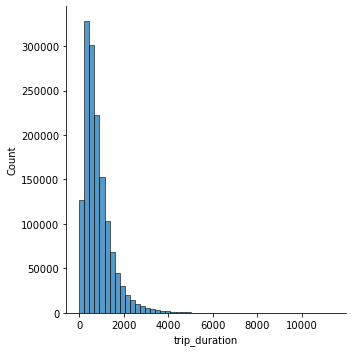

In [38]:
sns.displot(data.trip_duration, bins=50);

In [39]:
test_shapiro = stats.shapiro(data['trip_duration'])

print(test_shapiro)

if test_shapiro.pvalue < 0.05:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

ShapiroResult(statistic=0.8141791820526123, pvalue=0.0)
Распределение не нормальное


In [40]:
data.loc[:, 'log_trip_duration'] = np.log(data.trip_duration + 1)

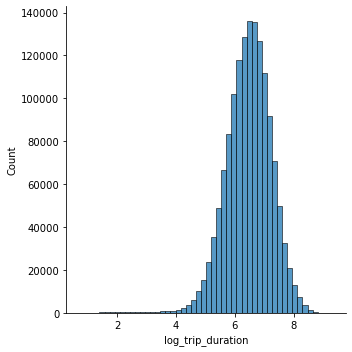

In [41]:
sns.displot(data.log_trip_duration, bins=50);

### Гипотезы

Гипотеза: компания такси не влияет на длительность поездки

Text(0, 0.5, 'Time')

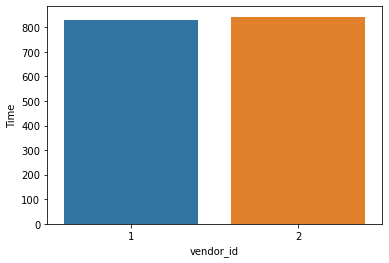

In [42]:
ven = df.groupby('vendor_id')['trip_duration'].mean()
sns.barplot(ven.index,ven.values)
plt.ylabel('Time')

Вывод: гипотеза подтвердилась, по графику не заметна существенная разница между длительностью поездки такси в различных компаниях

Гипотеза 2: количество пассажиров не влияют на длительность поездки.

<AxesSubplot:xlabel='passenger_count', ylabel='Time'>

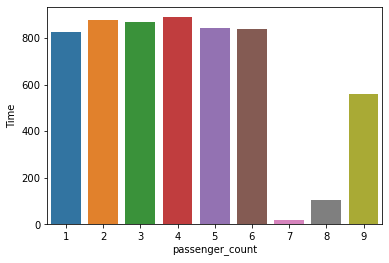

In [43]:
pc = data.groupby('passenger_count')['trip_duration'].mean()
plt.ylabel('Time')
sns.barplot(pc.index,pc.values)

In [44]:
data['passenger_count'].value_counts()

1    1032256
2     209998
5      77868
3      59777
6      48200
4      28347
7          3
9          1
8          1
Name: passenger_count, dtype: int64

Вывод: В целом средняя длительность поездки мало отличается. На графике видно, что для поездок с 7, 8 и 9 пассажирами длительность поездки была явно меньше, но записей с таким количеством пассажиров в наборе данных недостаточно, поэтому нельзя сделать однозначные выводы

Гипотеза 3: в течении дня длительность поездки меняется (пробки, час-пик)

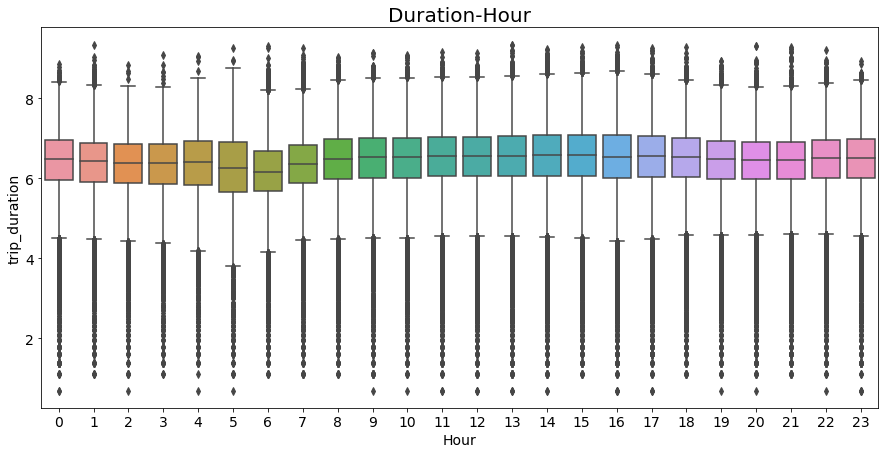

In [45]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='pickup_hour', y='log_trip_duration', data=data)

plt.title('Duration-Hour', fontsize=20)
plt.ylabel('trip_duration', fontsize=14)
plt.xlabel('Hour', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Вывод: как ни странно существенной разницы в длительности поедки в зависимости от времени не наблюдается.

Гипотеза 4: время влияет на количество поездок

In [46]:
norm_hours = (data['pickup_hour'].value_counts(normalize=True)
              .mul(100)
              .reset_index()
              .sort_values('pickup_hour'))

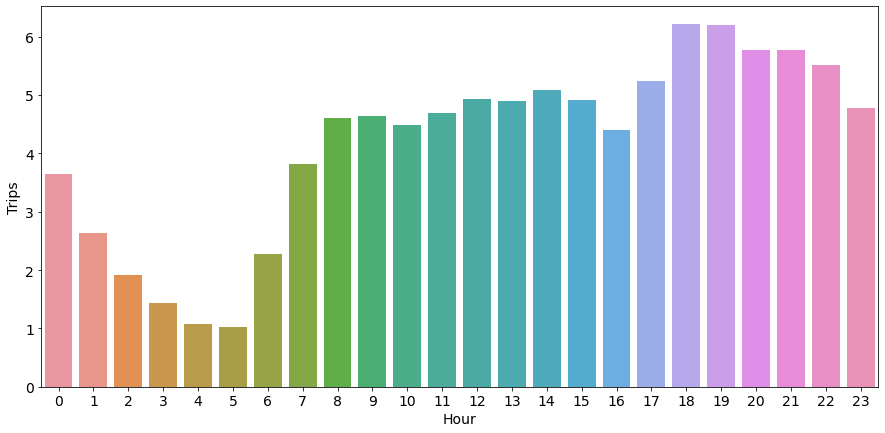

In [47]:
plt.figure(figsize=(15, 7))
ax = sns.barplot(x="index", y="pickup_hour", data=norm_hours)

plt.ylabel('Trips', fontsize=14)
plt.xlabel('Hour', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);


Вывод: действительно, по графику видно, что в утренние и вечерние часы количество поездок преобладает, а после 12 ночи постепенно снижается вплоть до 6-7 утра.

Построим тепловую карту, чтобы увидеть зависимости

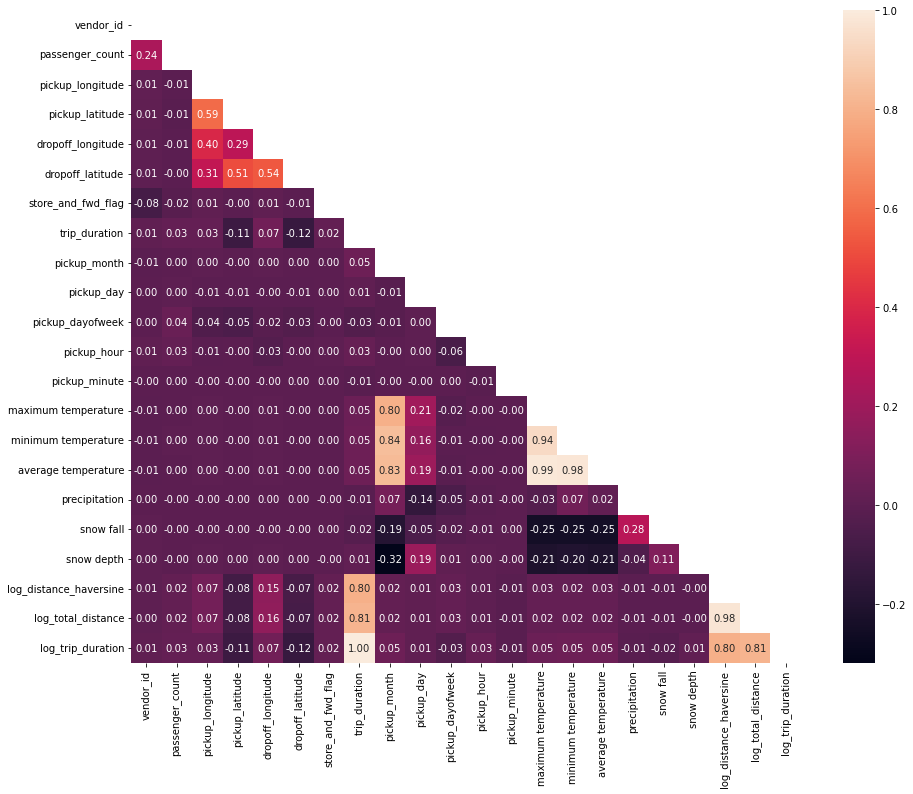

In [48]:
matrix = np.triu(data.drop(columns=['total_distance', 'distance_haversine']).corr(method='spearman'))

plt.figure(figsize=(15, 12))

sns.heatmap(data.drop(columns=['total_distance', 'distance_haversine']).corr(method='spearman'), annot=True, fmt=".2f",
           mask=matrix);

## BASELINE

In [49]:
import lightgbm as lg

import optuna

In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split, KFold

In [51]:
def r2_adjusted(y_true: list, y_pred: list, X_test: np.array) -> float:
    N_objects = len(y_true)
    N_features = X_test.shape[1]
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (N_objects - 1) / (N_objects - N_features - 1)


def mpe(y_true: list, y_pred: list) -> float:
    return np.mean((y_true - y_pred)/ y_true)


def mape(y_true: list, y_pred: list) -> float:
    return np.mean(np.abs((y_pred - y_true) / y_true))


def wape(y_true: list, y_pred: list) -> float:
    return np.sum(np.abs(y_pred - y_true)) / np.sum(y_true)


def huber_loss(y_true, y_pred, delta):
    assert len(y_true) == len(y_pred), 'Разные размеры данных'
    huber_sum = 0
    for i in range(len(y_true)):
        if abs(y_true[i] - y_pred[i]) < delta:
            huber_sum += 0.5 * (y_true[i] - y_pred[i])**2
        else:
            huber_sum += delta * (0.5 * abs(y_true[i] - y_pred[i]) -
                                  0.5 * delta)
    huber_sum /= len(y_true)
    return huber_sum


def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """
    The Root Mean Squared Log Error (RMSLE) metric 
    Логаритмическая ошибка средней квадратичной ошибки
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


def get_metrics(y_test, y_pred, X_test, name, delta):
    df_metrics = pd.DataFrame()
    
    df_metrics['model'] = [name]
    
    df_metrics['MAE'] = [mean_absolute_error(y_test, y_pred)]
    df_metrics['MSE'] = [mean_squared_error(y_test, y_pred)]
    df_metrics['RMSE'] = [np.sqrt(mean_squared_error(y_test, y_pred))]
    
    try:
        df_metrics['RMSLE'] = [rmsle(y_test, y_pred)]
    except:
        df_metrics['RMSLE'] = 0

    df_metrics['R2 adjusted'] = [r2_adjusted(y_test, y_pred, X_test)]
    df_metrics['Huber_loss'] = [huber_loss(y_test, y_pred, delta)]
    df_metrics['MPE_%'] = [mpe(y_test, y_pred)*100]
    df_metrics['MAPE_%'] = [mape(y_test, y_pred)*100]
    df_metrics['WAPE_%'] = [wape(y_test, y_pred)*100]
    
    return df_metrics

In [52]:
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'date', 'pickup_month', 'pickup_day',
       'pickup_dayofweek', 'pickup_hour', 'pickup_minute',
       'maximum temperature', 'minimum temperature', 'average temperature',
       'precipitation', 'snow fall', 'snow depth', 'total_distance',
       'distance_haversine', 'log_distance_haversine', 'log_total_distance',
       'log_trip_duration'],
      dtype='object')

In [53]:
drop_cols = [
    'id',
    'pickup_datetime',
    'dropoff_datetime',
    
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    
    'distance_haversine',
    
    'date',
    'total_distance',
    
    'trip_duration',
    'log_trip_duration'
]

In [54]:
X = data.drop(columns=drop_cols, axis=1)
y = data['log_trip_duration'].values

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RAND)

In [56]:
from sklearn.ensemble import GradientBoostingRegressor

In [57]:
model = GradientBoostingRegressor()

In [58]:
model.fit(X_train, y_train)

GradientBoostingRegressor()

In [59]:
y_test = np.exp(y_test)-1

In [60]:
y_test

array([ 636.,  570.,  813., ...,  848.,  453., 1039.])

In [61]:
y_pred = model.predict(X_test)
y_pred = np.exp(y_pred)-1

In [62]:
metrics = get_metrics(y_test, y_pred, X_test, name='GBR', delta=1)
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,Huber_loss,MPE_%,MAPE_%,WAPE_%
0,GBR,217.68888,124843.46086,353.33194,0.40412,0.71088,108.34615,-10.31828,33.24249,26.02591


In [63]:
model2 = lg.LGBMRegressor()
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
y_pred = np.exp(y_pred)-1
metrics = metrics.append(
    get_metrics(y_test, y_pred, X_test, name='LGBM', delta=1))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,Huber_loss,MPE_%,MAPE_%,WAPE_%
0,GBR,217.68888,124843.46086,353.33194,0.40412,0.71088,108.34615,-10.31828,33.24249,26.02591
0,LGBM,210.34511,115447.73224,339.77600,0.39571,0.73264,104.67431,-9.99720,32.30414,25.14792


In [64]:
import xgboost as xg

In [65]:
model3 = xg.XGBRegressor()
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
y_pred = np.exp(y_pred)-1
metrics = metrics.append(
    get_metrics(y_test, y_pred, X_test, name='XGB', delta=1))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,Huber_loss,MPE_%,MAPE_%,WAPE_%
0,GBR,217.68888,124843.46086,353.33194,0.40412,0.71088,108.34615,-10.31828,33.24249,26.02591
0,LGBM,210.34511,115447.73224,339.77600,0.39571,0.73264,104.67431,-9.99720,32.30414,25.14792
0,XGB,207.62358,111026.28626,333.20607,0.39168,0.74288,103.31367,-9.59430,31.73920,24.82254


In [66]:
from catboost import CatBoostRegressor

In [67]:
model4 = CatBoostRegressor()
model4.fit(X_train, y_train)
y_pred = model4.predict(X_test)
y_pred = np.exp(y_pred)-1
metrics = metrics.append(
    get_metrics(y_test, y_pred, X_test, name='CatBoost', delta=1))
metrics

Learning rate set to 0.13559
0:	learn: 0.7103205	total: 226ms	remaining: 3m 45s
1:	learn: 0.6572110	total: 335ms	remaining: 2m 46s
2:	learn: 0.6129936	total: 443ms	remaining: 2m 27s
3:	learn: 0.5774474	total: 550ms	remaining: 2m 16s
4:	learn: 0.5482589	total: 637ms	remaining: 2m 6s
5:	learn: 0.5247553	total: 726ms	remaining: 2m
6:	learn: 0.5053871	total: 812ms	remaining: 1m 55s
7:	learn: 0.4891219	total: 898ms	remaining: 1m 51s
8:	learn: 0.4762694	total: 1000ms	remaining: 1m 50s
9:	learn: 0.4657185	total: 1.09s	remaining: 1m 48s
10:	learn: 0.4574317	total: 1.18s	remaining: 1m 46s
11:	learn: 0.4504018	total: 1.26s	remaining: 1m 44s
12:	learn: 0.4449473	total: 1.36s	remaining: 1m 43s
13:	learn: 0.4400572	total: 1.47s	remaining: 1m 43s
14:	learn: 0.4357573	total: 1.55s	remaining: 1m 42s
15:	learn: 0.4321966	total: 1.67s	remaining: 1m 42s
16:	learn: 0.4294153	total: 1.77s	remaining: 1m 42s
17:	learn: 0.4268549	total: 1.85s	remaining: 1m 41s
18:	learn: 0.4247902	total: 1.94s	remaining: 1m 4

158:	learn: 0.3948750	total: 13.9s	remaining: 1m 13s
159:	learn: 0.3948258	total: 14s	remaining: 1m 13s
160:	learn: 0.3947911	total: 14.1s	remaining: 1m 13s
161:	learn: 0.3947587	total: 14.1s	remaining: 1m 13s
162:	learn: 0.3947249	total: 14.2s	remaining: 1m 12s
163:	learn: 0.3946809	total: 14.3s	remaining: 1m 12s
164:	learn: 0.3946521	total: 14.4s	remaining: 1m 12s
165:	learn: 0.3946156	total: 14.5s	remaining: 1m 12s
166:	learn: 0.3945703	total: 14.6s	remaining: 1m 12s
167:	learn: 0.3945348	total: 14.7s	remaining: 1m 12s
168:	learn: 0.3945129	total: 14.7s	remaining: 1m 12s
169:	learn: 0.3944473	total: 14.8s	remaining: 1m 12s
170:	learn: 0.3943976	total: 14.9s	remaining: 1m 12s
171:	learn: 0.3943566	total: 15s	remaining: 1m 12s
172:	learn: 0.3943241	total: 15.1s	remaining: 1m 12s
173:	learn: 0.3942681	total: 15.2s	remaining: 1m 11s
174:	learn: 0.3942399	total: 15.2s	remaining: 1m 11s
175:	learn: 0.3942082	total: 15.3s	remaining: 1m 11s
176:	learn: 0.3941681	total: 15.4s	remaining: 1m 1

319:	learn: 0.3906862	total: 27.4s	remaining: 58.3s
320:	learn: 0.3906664	total: 27.5s	remaining: 58.2s
321:	learn: 0.3906467	total: 27.6s	remaining: 58.2s
322:	learn: 0.3906206	total: 27.7s	remaining: 58.1s
323:	learn: 0.3906058	total: 27.8s	remaining: 58s
324:	learn: 0.3905866	total: 27.9s	remaining: 57.9s
325:	learn: 0.3905786	total: 28s	remaining: 57.9s
326:	learn: 0.3905559	total: 28.1s	remaining: 57.8s
327:	learn: 0.3905283	total: 28.2s	remaining: 57.8s
328:	learn: 0.3905121	total: 28.3s	remaining: 57.7s
329:	learn: 0.3905016	total: 28.4s	remaining: 57.6s
330:	learn: 0.3904568	total: 28.5s	remaining: 57.6s
331:	learn: 0.3904294	total: 28.6s	remaining: 57.5s
332:	learn: 0.3904185	total: 28.7s	remaining: 57.4s
333:	learn: 0.3903903	total: 28.8s	remaining: 57.4s
334:	learn: 0.3903608	total: 28.9s	remaining: 57.3s
335:	learn: 0.3903531	total: 29s	remaining: 57.2s
336:	learn: 0.3903394	total: 29s	remaining: 57.1s
337:	learn: 0.3903295	total: 29.1s	remaining: 57.1s
338:	learn: 0.390307

479:	learn: 0.3883147	total: 41.7s	remaining: 45.2s
480:	learn: 0.3883037	total: 41.8s	remaining: 45.1s
481:	learn: 0.3882708	total: 41.9s	remaining: 45s
482:	learn: 0.3882545	total: 42s	remaining: 44.9s
483:	learn: 0.3882278	total: 42s	remaining: 44.8s
484:	learn: 0.3882208	total: 42.1s	remaining: 44.7s
485:	learn: 0.3882115	total: 42.2s	remaining: 44.7s
486:	learn: 0.3882059	total: 42.3s	remaining: 44.6s
487:	learn: 0.3881853	total: 42.4s	remaining: 44.5s
488:	learn: 0.3881729	total: 42.5s	remaining: 44.4s
489:	learn: 0.3881694	total: 42.6s	remaining: 44.3s
490:	learn: 0.3881518	total: 42.7s	remaining: 44.2s
491:	learn: 0.3881314	total: 42.7s	remaining: 44.1s
492:	learn: 0.3881094	total: 42.8s	remaining: 44s
493:	learn: 0.3881012	total: 42.9s	remaining: 44s
494:	learn: 0.3880839	total: 43s	remaining: 43.9s
495:	learn: 0.3880609	total: 43.1s	remaining: 43.8s
496:	learn: 0.3880452	total: 43.2s	remaining: 43.7s
497:	learn: 0.3880263	total: 43.3s	remaining: 43.6s
498:	learn: 0.3880055	to

638:	learn: 0.3862311	total: 55.7s	remaining: 31.5s
639:	learn: 0.3862179	total: 55.8s	remaining: 31.4s
640:	learn: 0.3862114	total: 56s	remaining: 31.3s
641:	learn: 0.3861870	total: 56.1s	remaining: 31.3s
642:	learn: 0.3861786	total: 56.2s	remaining: 31.2s
643:	learn: 0.3861546	total: 56.3s	remaining: 31.1s
644:	learn: 0.3861490	total: 56.4s	remaining: 31s
645:	learn: 0.3861387	total: 56.5s	remaining: 31s
646:	learn: 0.3861226	total: 56.6s	remaining: 30.9s
647:	learn: 0.3861000	total: 56.7s	remaining: 30.8s
648:	learn: 0.3860926	total: 56.8s	remaining: 30.7s
649:	learn: 0.3860822	total: 56.9s	remaining: 30.6s
650:	learn: 0.3860737	total: 57s	remaining: 30.5s
651:	learn: 0.3860699	total: 57.1s	remaining: 30.5s
652:	learn: 0.3860667	total: 57.2s	remaining: 30.4s
653:	learn: 0.3860611	total: 57.3s	remaining: 30.3s
654:	learn: 0.3860533	total: 57.4s	remaining: 30.2s
655:	learn: 0.3860469	total: 57.5s	remaining: 30.1s
656:	learn: 0.3860426	total: 57.6s	remaining: 30.1s
657:	learn: 0.386034

799:	learn: 0.3845993	total: 1m 10s	remaining: 17.6s
800:	learn: 0.3845885	total: 1m 10s	remaining: 17.5s
801:	learn: 0.3845794	total: 1m 10s	remaining: 17.4s
802:	learn: 0.3845751	total: 1m 10s	remaining: 17.3s
803:	learn: 0.3845637	total: 1m 10s	remaining: 17.3s
804:	learn: 0.3845552	total: 1m 10s	remaining: 17.2s
805:	learn: 0.3845506	total: 1m 10s	remaining: 17.1s
806:	learn: 0.3845394	total: 1m 11s	remaining: 17s
807:	learn: 0.3845272	total: 1m 11s	remaining: 16.9s
808:	learn: 0.3845225	total: 1m 11s	remaining: 16.8s
809:	learn: 0.3845081	total: 1m 11s	remaining: 16.7s
810:	learn: 0.3844950	total: 1m 11s	remaining: 16.6s
811:	learn: 0.3844840	total: 1m 11s	remaining: 16.5s
812:	learn: 0.3844840	total: 1m 11s	remaining: 16.5s
813:	learn: 0.3844747	total: 1m 11s	remaining: 16.4s
814:	learn: 0.3844671	total: 1m 11s	remaining: 16.3s
815:	learn: 0.3844496	total: 1m 11s	remaining: 16.2s
816:	learn: 0.3844311	total: 1m 11s	remaining: 16.1s
817:	learn: 0.3844262	total: 1m 11s	remaining: 1

955:	learn: 0.3831565	total: 1m 23s	remaining: 3.86s
956:	learn: 0.3831533	total: 1m 24s	remaining: 3.77s
957:	learn: 0.3831420	total: 1m 24s	remaining: 3.69s
958:	learn: 0.3831374	total: 1m 24s	remaining: 3.6s
959:	learn: 0.3831311	total: 1m 24s	remaining: 3.51s
960:	learn: 0.3831267	total: 1m 24s	remaining: 3.42s
961:	learn: 0.3831136	total: 1m 24s	remaining: 3.34s
962:	learn: 0.3831016	total: 1m 24s	remaining: 3.25s
963:	learn: 0.3830954	total: 1m 24s	remaining: 3.16s
964:	learn: 0.3830827	total: 1m 24s	remaining: 3.07s
965:	learn: 0.3830717	total: 1m 24s	remaining: 2.98s
966:	learn: 0.3830539	total: 1m 24s	remaining: 2.9s
967:	learn: 0.3830395	total: 1m 25s	remaining: 2.81s
968:	learn: 0.3830317	total: 1m 25s	remaining: 2.72s
969:	learn: 0.3830218	total: 1m 25s	remaining: 2.63s
970:	learn: 0.3830193	total: 1m 25s	remaining: 2.55s
971:	learn: 0.3830117	total: 1m 25s	remaining: 2.46s
972:	learn: 0.3829952	total: 1m 25s	remaining: 2.37s
973:	learn: 0.3829908	total: 1m 25s	remaining: 2

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,Huber_loss,MPE_%,MAPE_%,WAPE_%
0,GBR,217.68888,124843.46086,353.33194,0.40412,0.71088,108.34615,-10.31828,33.24249,26.02591
0,LGBM,210.34511,115447.73224,339.77600,0.39571,0.73264,104.67431,-9.99720,32.30414,25.14792
0,XGB,207.62358,111026.28626,333.20607,0.39168,0.74288,103.31367,-9.59430,31.73920,24.82254
0,CatBoost,206.51765,110308.57938,332.12735,0.39281,0.74454,102.76074,-9.93980,31.99481,24.69032


## Подбор параметров

In [68]:
def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [69]:
def objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [1000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10, step=2),
        "eval_metric": "rmsle",
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 10, 1000),
        "subsample": trial.suggest_loguniform("subsample", 0.4, 0.8),
        "gamma": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "subsample": trial.suggest_loguniform("subsample", 0.4, 0.8),
        "alpha": trial.suggest_loguniform("alpha", 0.01, 10.0),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.6),
    }
    cv = KFold(n_splits=5, shuffle=True, random_state=RAND)
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-rmsle")
    
    cv_predicts = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = xg.XGBRegressor(**param_grid)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  early_stopping_rounds=100,
                  callbacks=[pruning_callback],
                  verbose=0)
        preds = model.predict(X_test)        
        cv_predicts[idx] = rmsle(y_test, preds)

    return np.mean(cv_predicts)

In [70]:
study = optuna.create_study(direction="minimize", study_name="XGB")
func = lambda trial: objective(trial, X_train, y_train)
study.optimize(func, n_trials=2, show_progress_bar=True)

[I 2022-06-28 11:48:03,750] A new study created in memory with name: XGB


  0%|          | 0/2 [00:00<?, ?it/s]

[I 2022-06-28 12:09:06,378] Trial 0 finished with value: 0.0607205666021684 and parameters: {'n_estimators': 1000, 'learning_rate': 0.03106341249162673, 'max_depth': 3, 'min_child_weight': 18.5919986986435, 'subsample': 0.40936206737494113, 'lambda': 1.6380800606228506e-06, 'alpha': 0.031528508091758715, 'colsample_bytree': 0.3151107951527303}. Best is trial 0 with value: 0.0607205666021684.
[I 2022-06-28 13:00:08,947] Trial 1 finished with value: 0.0591943871272824 and parameters: {'n_estimators': 1000, 'learning_rate': 0.047629277973497745, 'max_depth': 9, 'min_child_weight': 503.74545706158597, 'subsample': 0.6997632013049524, 'lambda': 0.0032709078853386067, 'alpha': 0.965739518905994, 'colsample_bytree': 0.3421703002530903}. Best is trial 1 with value: 0.0591943871272824.


In [86]:
study.best_value

0.0591943871272824

In [85]:
study.best_params

{'n_estimators': 1000,
 'learning_rate': 0.047629277973497745,
 'max_depth': 9,
 'min_child_weight': 503.74545706158597,
 'subsample': 0.6997632013049524,
 'lambda': 0.0032709078853386067,
 'alpha': 0.965739518905994,
 'colsample_bytree': 0.3421703002530903}

In [74]:
cv = KFold(n_splits=5, shuffle=True, random_state=RAND)

finish_test_preds = []
cv_predicts = np.empty(5)

for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val = y_train[train_idx], y_train[test_idx]

    model = xg.XGBRegressor(**study.best_params)
    model.fit(X_train_,
              y_train_,
              eval_set=[(X_val, y_val)],
              eval_metric="rmsle",
              early_stopping_rounds=100)
    preds = model.predict(X_val)
    preds_exp = np.exp(preds) - 1
    y_val_exp = np.exp(y_val) - 1
    
    cv_predicts[idx] = rmsle(y_val_exp, preds_exp)
    preds_test = model.predict(X_test)
    finish_test_preds.append(preds_test)
    
    print(f"id = {idx}", cv_predicts[idx], '\n')

print(np.mean(cv_predicts))

[0]	validation_0-rmsle:1.42927
[1]	validation_0-rmsle:1.28783
[2]	validation_0-rmsle:1.17019
[3]	validation_0-rmsle:1.06984
[4]	validation_0-rmsle:0.98292
[5]	validation_0-rmsle:0.90674
[6]	validation_0-rmsle:0.83932
[7]	validation_0-rmsle:0.77916
[8]	validation_0-rmsle:0.72442
[9]	validation_0-rmsle:0.67565
[10]	validation_0-rmsle:0.63072
[11]	validation_0-rmsle:0.58986
[12]	validation_0-rmsle:0.55295
[13]	validation_0-rmsle:0.51864
[14]	validation_0-rmsle:0.48748
[15]	validation_0-rmsle:0.45878
[16]	validation_0-rmsle:0.43228
[17]	validation_0-rmsle:0.40777
[18]	validation_0-rmsle:0.38444
[19]	validation_0-rmsle:0.36281
[20]	validation_0-rmsle:0.34317
[21]	validation_0-rmsle:0.32438
[22]	validation_0-rmsle:0.30735
[23]	validation_0-rmsle:0.29148
[24]	validation_0-rmsle:0.27614
[25]	validation_0-rmsle:0.26228
[26]	validation_0-rmsle:0.24882
[27]	validation_0-rmsle:0.23673
[28]	validation_0-rmsle:0.22494
[29]	validation_0-rmsle:0.21388
[30]	validation_0-rmsle:0.20352
[31]	validation_0-

[252]	validation_0-rmsle:0.05931
[253]	validation_0-rmsle:0.05930
[254]	validation_0-rmsle:0.05930
[255]	validation_0-rmsle:0.05930
[256]	validation_0-rmsle:0.05930
[257]	validation_0-rmsle:0.05930
[258]	validation_0-rmsle:0.05928
[259]	validation_0-rmsle:0.05925
[260]	validation_0-rmsle:0.05925
[261]	validation_0-rmsle:0.05925
[262]	validation_0-rmsle:0.05923
[263]	validation_0-rmsle:0.05923
[264]	validation_0-rmsle:0.05922
[265]	validation_0-rmsle:0.05922
[266]	validation_0-rmsle:0.05922
[267]	validation_0-rmsle:0.05922
[268]	validation_0-rmsle:0.05922
[269]	validation_0-rmsle:0.05922
[270]	validation_0-rmsle:0.05922
[271]	validation_0-rmsle:0.05922
[272]	validation_0-rmsle:0.05920
[273]	validation_0-rmsle:0.05919
[274]	validation_0-rmsle:0.05918
[275]	validation_0-rmsle:0.05918
[276]	validation_0-rmsle:0.05918
[277]	validation_0-rmsle:0.05918
[278]	validation_0-rmsle:0.05918
[279]	validation_0-rmsle:0.05917
[280]	validation_0-rmsle:0.05916
[281]	validation_0-rmsle:0.05916
[282]	vali

[501]	validation_0-rmsle:0.05871
[502]	validation_0-rmsle:0.05871
[503]	validation_0-rmsle:0.05871
[504]	validation_0-rmsle:0.05871
[505]	validation_0-rmsle:0.05870
[506]	validation_0-rmsle:0.05870
[507]	validation_0-rmsle:0.05871
[508]	validation_0-rmsle:0.05869
[509]	validation_0-rmsle:0.05869
[510]	validation_0-rmsle:0.05869
[511]	validation_0-rmsle:0.05869
[512]	validation_0-rmsle:0.05869
[513]	validation_0-rmsle:0.05869
[514]	validation_0-rmsle:0.05869
[515]	validation_0-rmsle:0.05869
[516]	validation_0-rmsle:0.05869
[517]	validation_0-rmsle:0.05869
[518]	validation_0-rmsle:0.05869
[519]	validation_0-rmsle:0.05869
[520]	validation_0-rmsle:0.05868
[521]	validation_0-rmsle:0.05868
[522]	validation_0-rmsle:0.05868
[523]	validation_0-rmsle:0.05868
[524]	validation_0-rmsle:0.05868
[525]	validation_0-rmsle:0.05868
[526]	validation_0-rmsle:0.05867
[527]	validation_0-rmsle:0.05867
[528]	validation_0-rmsle:0.05867
[529]	validation_0-rmsle:0.05867
[530]	validation_0-rmsle:0.05867
[531]	vali

[750]	validation_0-rmsle:0.05858
[751]	validation_0-rmsle:0.05858
[752]	validation_0-rmsle:0.05858
[753]	validation_0-rmsle:0.05858
[754]	validation_0-rmsle:0.05858
[755]	validation_0-rmsle:0.05858
[756]	validation_0-rmsle:0.05858
[757]	validation_0-rmsle:0.05858
[758]	validation_0-rmsle:0.05858
[759]	validation_0-rmsle:0.05858
[760]	validation_0-rmsle:0.05858
[761]	validation_0-rmsle:0.05858
[762]	validation_0-rmsle:0.05858
[763]	validation_0-rmsle:0.05858
[764]	validation_0-rmsle:0.05857
[765]	validation_0-rmsle:0.05857
[766]	validation_0-rmsle:0.05857
[767]	validation_0-rmsle:0.05857
[768]	validation_0-rmsle:0.05857
[769]	validation_0-rmsle:0.05857
[770]	validation_0-rmsle:0.05857
[771]	validation_0-rmsle:0.05857
[772]	validation_0-rmsle:0.05857
[773]	validation_0-rmsle:0.05857
[774]	validation_0-rmsle:0.05857
[775]	validation_0-rmsle:0.05857
[776]	validation_0-rmsle:0.05857
[777]	validation_0-rmsle:0.05857
[778]	validation_0-rmsle:0.05857
[779]	validation_0-rmsle:0.05857
[780]	vali

[999]	validation_0-rmsle:0.05852
id = 0 0.38836993130451763 

[0]	validation_0-rmsle:1.42928
[1]	validation_0-rmsle:1.28783
[2]	validation_0-rmsle:1.17021
[3]	validation_0-rmsle:1.06988
[4]	validation_0-rmsle:0.98300
[5]	validation_0-rmsle:0.90683
[6]	validation_0-rmsle:0.83942
[7]	validation_0-rmsle:0.77929
[8]	validation_0-rmsle:0.72455
[9]	validation_0-rmsle:0.67580
[10]	validation_0-rmsle:0.63085
[11]	validation_0-rmsle:0.58999
[12]	validation_0-rmsle:0.55312
[13]	validation_0-rmsle:0.51880
[14]	validation_0-rmsle:0.48767
[15]	validation_0-rmsle:0.45899
[16]	validation_0-rmsle:0.43251
[17]	validation_0-rmsle:0.40801
[18]	validation_0-rmsle:0.38469
[19]	validation_0-rmsle:0.36305
[20]	validation_0-rmsle:0.34345
[21]	validation_0-rmsle:0.32466
[22]	validation_0-rmsle:0.30766
[23]	validation_0-rmsle:0.29180
[24]	validation_0-rmsle:0.27647
[25]	validation_0-rmsle:0.26265
[26]	validation_0-rmsle:0.24920
[27]	validation_0-rmsle:0.23713
[28]	validation_0-rmsle:0.22535
[29]	validation_0-rm

[250]	validation_0-rmsle:0.06014
[251]	validation_0-rmsle:0.06013
[252]	validation_0-rmsle:0.06012
[253]	validation_0-rmsle:0.06012
[254]	validation_0-rmsle:0.06012
[255]	validation_0-rmsle:0.06011
[256]	validation_0-rmsle:0.06011
[257]	validation_0-rmsle:0.06010
[258]	validation_0-rmsle:0.06008
[259]	validation_0-rmsle:0.06005
[260]	validation_0-rmsle:0.06005
[261]	validation_0-rmsle:0.06005
[262]	validation_0-rmsle:0.06003
[263]	validation_0-rmsle:0.06003
[264]	validation_0-rmsle:0.06002
[265]	validation_0-rmsle:0.06002
[266]	validation_0-rmsle:0.06002
[267]	validation_0-rmsle:0.06002
[268]	validation_0-rmsle:0.06002
[269]	validation_0-rmsle:0.06001
[270]	validation_0-rmsle:0.06001
[271]	validation_0-rmsle:0.06001
[272]	validation_0-rmsle:0.05999
[273]	validation_0-rmsle:0.05997
[274]	validation_0-rmsle:0.05997
[275]	validation_0-rmsle:0.05996
[276]	validation_0-rmsle:0.05996
[277]	validation_0-rmsle:0.05996
[278]	validation_0-rmsle:0.05996
[279]	validation_0-rmsle:0.05995
[280]	vali

[499]	validation_0-rmsle:0.05938
[500]	validation_0-rmsle:0.05938
[501]	validation_0-rmsle:0.05938
[502]	validation_0-rmsle:0.05938
[503]	validation_0-rmsle:0.05938
[504]	validation_0-rmsle:0.05938
[505]	validation_0-rmsle:0.05937
[506]	validation_0-rmsle:0.05937
[507]	validation_0-rmsle:0.05938
[508]	validation_0-rmsle:0.05937
[509]	validation_0-rmsle:0.05937
[510]	validation_0-rmsle:0.05937
[511]	validation_0-rmsle:0.05937
[512]	validation_0-rmsle:0.05937
[513]	validation_0-rmsle:0.05937
[514]	validation_0-rmsle:0.05937
[515]	validation_0-rmsle:0.05937
[516]	validation_0-rmsle:0.05936
[517]	validation_0-rmsle:0.05936
[518]	validation_0-rmsle:0.05936
[519]	validation_0-rmsle:0.05935
[520]	validation_0-rmsle:0.05935
[521]	validation_0-rmsle:0.05935
[522]	validation_0-rmsle:0.05935
[523]	validation_0-rmsle:0.05935
[524]	validation_0-rmsle:0.05935
[525]	validation_0-rmsle:0.05935
[526]	validation_0-rmsle:0.05934
[527]	validation_0-rmsle:0.05933
[528]	validation_0-rmsle:0.05933
[529]	vali

[748]	validation_0-rmsle:0.05921
[749]	validation_0-rmsle:0.05921
[750]	validation_0-rmsle:0.05921
[751]	validation_0-rmsle:0.05921
[752]	validation_0-rmsle:0.05921
[753]	validation_0-rmsle:0.05921
[754]	validation_0-rmsle:0.05921
[755]	validation_0-rmsle:0.05921
[756]	validation_0-rmsle:0.05921
[757]	validation_0-rmsle:0.05921
[758]	validation_0-rmsle:0.05921
[759]	validation_0-rmsle:0.05921
[760]	validation_0-rmsle:0.05921
[761]	validation_0-rmsle:0.05921
[762]	validation_0-rmsle:0.05920
[763]	validation_0-rmsle:0.05920
[764]	validation_0-rmsle:0.05920
[765]	validation_0-rmsle:0.05920
[766]	validation_0-rmsle:0.05920
[767]	validation_0-rmsle:0.05920
[768]	validation_0-rmsle:0.05920
[769]	validation_0-rmsle:0.05920
[770]	validation_0-rmsle:0.05920
[771]	validation_0-rmsle:0.05920
[772]	validation_0-rmsle:0.05920
[773]	validation_0-rmsle:0.05920
[774]	validation_0-rmsle:0.05920
[775]	validation_0-rmsle:0.05920
[776]	validation_0-rmsle:0.05920
[777]	validation_0-rmsle:0.05920
[778]	vali

[997]	validation_0-rmsle:0.05914
[998]	validation_0-rmsle:0.05914
[999]	validation_0-rmsle:0.05914
id = 1 0.38887070092883547 

[0]	validation_0-rmsle:1.42923
[1]	validation_0-rmsle:1.28781
[2]	validation_0-rmsle:1.17017
[3]	validation_0-rmsle:1.06983
[4]	validation_0-rmsle:0.98291
[5]	validation_0-rmsle:0.90674
[6]	validation_0-rmsle:0.83932
[7]	validation_0-rmsle:0.77919
[8]	validation_0-rmsle:0.72446
[9]	validation_0-rmsle:0.67568
[10]	validation_0-rmsle:0.63076
[11]	validation_0-rmsle:0.58992
[12]	validation_0-rmsle:0.55302
[13]	validation_0-rmsle:0.51871
[14]	validation_0-rmsle:0.48757
[15]	validation_0-rmsle:0.45887
[16]	validation_0-rmsle:0.43239
[17]	validation_0-rmsle:0.40789
[18]	validation_0-rmsle:0.38458
[19]	validation_0-rmsle:0.36295
[20]	validation_0-rmsle:0.34332
[21]	validation_0-rmsle:0.32455
[22]	validation_0-rmsle:0.30754
[23]	validation_0-rmsle:0.29167
[24]	validation_0-rmsle:0.27634
[25]	validation_0-rmsle:0.26251
[26]	validation_0-rmsle:0.24906
[27]	validation_0-

[248]	validation_0-rmsle:0.05987
[249]	validation_0-rmsle:0.05986
[250]	validation_0-rmsle:0.05984
[251]	validation_0-rmsle:0.05984
[252]	validation_0-rmsle:0.05983
[253]	validation_0-rmsle:0.05983
[254]	validation_0-rmsle:0.05983
[255]	validation_0-rmsle:0.05982
[256]	validation_0-rmsle:0.05982
[257]	validation_0-rmsle:0.05982
[258]	validation_0-rmsle:0.05980
[259]	validation_0-rmsle:0.05978
[260]	validation_0-rmsle:0.05978
[261]	validation_0-rmsle:0.05978
[262]	validation_0-rmsle:0.05976
[263]	validation_0-rmsle:0.05976
[264]	validation_0-rmsle:0.05975
[265]	validation_0-rmsle:0.05975
[266]	validation_0-rmsle:0.05975
[267]	validation_0-rmsle:0.05975
[268]	validation_0-rmsle:0.05975
[269]	validation_0-rmsle:0.05974
[270]	validation_0-rmsle:0.05974
[271]	validation_0-rmsle:0.05974
[272]	validation_0-rmsle:0.05973
[273]	validation_0-rmsle:0.05971
[274]	validation_0-rmsle:0.05971
[275]	validation_0-rmsle:0.05970
[276]	validation_0-rmsle:0.05970
[277]	validation_0-rmsle:0.05970
[278]	vali

[497]	validation_0-rmsle:0.05917
[498]	validation_0-rmsle:0.05916
[499]	validation_0-rmsle:0.05916
[500]	validation_0-rmsle:0.05916
[501]	validation_0-rmsle:0.05916
[502]	validation_0-rmsle:0.05916
[503]	validation_0-rmsle:0.05917
[504]	validation_0-rmsle:0.05917
[505]	validation_0-rmsle:0.05916
[506]	validation_0-rmsle:0.05916
[507]	validation_0-rmsle:0.05916
[508]	validation_0-rmsle:0.05916
[509]	validation_0-rmsle:0.05916
[510]	validation_0-rmsle:0.05915
[511]	validation_0-rmsle:0.05915
[512]	validation_0-rmsle:0.05915
[513]	validation_0-rmsle:0.05915
[514]	validation_0-rmsle:0.05916
[515]	validation_0-rmsle:0.05916
[516]	validation_0-rmsle:0.05915
[517]	validation_0-rmsle:0.05915
[518]	validation_0-rmsle:0.05915
[519]	validation_0-rmsle:0.05915
[520]	validation_0-rmsle:0.05914
[521]	validation_0-rmsle:0.05914
[522]	validation_0-rmsle:0.05914
[523]	validation_0-rmsle:0.05914
[524]	validation_0-rmsle:0.05914
[525]	validation_0-rmsle:0.05914
[526]	validation_0-rmsle:0.05913
[527]	vali

[746]	validation_0-rmsle:0.05904
[747]	validation_0-rmsle:0.05904
[748]	validation_0-rmsle:0.05904
[749]	validation_0-rmsle:0.05904
[750]	validation_0-rmsle:0.05904
[751]	validation_0-rmsle:0.05904
[752]	validation_0-rmsle:0.05904
[753]	validation_0-rmsle:0.05904
[754]	validation_0-rmsle:0.05904
[755]	validation_0-rmsle:0.05904
[756]	validation_0-rmsle:0.05904
[757]	validation_0-rmsle:0.05904
[758]	validation_0-rmsle:0.05904
[759]	validation_0-rmsle:0.05904
[760]	validation_0-rmsle:0.05904
[761]	validation_0-rmsle:0.05904
[762]	validation_0-rmsle:0.05904
[763]	validation_0-rmsle:0.05904
[764]	validation_0-rmsle:0.05904
[765]	validation_0-rmsle:0.05904
[766]	validation_0-rmsle:0.05904
[767]	validation_0-rmsle:0.05903
[768]	validation_0-rmsle:0.05903
[769]	validation_0-rmsle:0.05903
[770]	validation_0-rmsle:0.05903
[771]	validation_0-rmsle:0.05903
[772]	validation_0-rmsle:0.05903
[773]	validation_0-rmsle:0.05903
[774]	validation_0-rmsle:0.05903
[775]	validation_0-rmsle:0.05903
[776]	vali

[995]	validation_0-rmsle:0.05898
[996]	validation_0-rmsle:0.05898
[997]	validation_0-rmsle:0.05898
[998]	validation_0-rmsle:0.05898
[999]	validation_0-rmsle:0.05898
id = 2 0.38974503934531013 

[0]	validation_0-rmsle:1.42904
[1]	validation_0-rmsle:1.28761
[2]	validation_0-rmsle:1.16951
[3]	validation_0-rmsle:1.06910
[4]	validation_0-rmsle:0.98177
[5]	validation_0-rmsle:0.90523
[6]	validation_0-rmsle:0.83751
[7]	validation_0-rmsle:0.77708
[8]	validation_0-rmsle:0.72285
[9]	validation_0-rmsle:0.67375
[10]	validation_0-rmsle:0.62921
[11]	validation_0-rmsle:0.58859
[12]	validation_0-rmsle:0.55143
[13]	validation_0-rmsle:0.51735
[14]	validation_0-rmsle:0.48599
[15]	validation_0-rmsle:0.45711
[16]	validation_0-rmsle:0.43030
[17]	validation_0-rmsle:0.40546
[18]	validation_0-rmsle:0.38242
[19]	validation_0-rmsle:0.36109
[20]	validation_0-rmsle:0.34114
[21]	validation_0-rmsle:0.32253
[22]	validation_0-rmsle:0.30520
[23]	validation_0-rmsle:0.28900
[24]	validation_0-rmsle:0.27386
[25]	validation_

[246]	validation_0-rmsle:0.06051
[247]	validation_0-rmsle:0.06051
[248]	validation_0-rmsle:0.06051
[249]	validation_0-rmsle:0.06050
[250]	validation_0-rmsle:0.06050
[251]	validation_0-rmsle:0.06049
[252]	validation_0-rmsle:0.06049
[253]	validation_0-rmsle:0.06049
[254]	validation_0-rmsle:0.06049
[255]	validation_0-rmsle:0.06049
[256]	validation_0-rmsle:0.06048
[257]	validation_0-rmsle:0.06048
[258]	validation_0-rmsle:0.06048
[259]	validation_0-rmsle:0.06047
[260]	validation_0-rmsle:0.06047
[261]	validation_0-rmsle:0.06047
[262]	validation_0-rmsle:0.06047
[263]	validation_0-rmsle:0.06047
[264]	validation_0-rmsle:0.06047
[265]	validation_0-rmsle:0.06047
[266]	validation_0-rmsle:0.06047
[267]	validation_0-rmsle:0.06046
[268]	validation_0-rmsle:0.06046
[269]	validation_0-rmsle:0.06046
[270]	validation_0-rmsle:0.06047
[271]	validation_0-rmsle:0.06046
[272]	validation_0-rmsle:0.06046
[273]	validation_0-rmsle:0.06046
[274]	validation_0-rmsle:0.06045
[275]	validation_0-rmsle:0.06046
[276]	vali

[495]	validation_0-rmsle:0.05995
[496]	validation_0-rmsle:0.05995
[497]	validation_0-rmsle:0.05995
[498]	validation_0-rmsle:0.05995
[499]	validation_0-rmsle:0.05995
[500]	validation_0-rmsle:0.05995
[501]	validation_0-rmsle:0.05995
[502]	validation_0-rmsle:0.05995
[503]	validation_0-rmsle:0.05995
[504]	validation_0-rmsle:0.05995
[505]	validation_0-rmsle:0.05994
[506]	validation_0-rmsle:0.05994
[507]	validation_0-rmsle:0.05995
[508]	validation_0-rmsle:0.05995
[509]	validation_0-rmsle:0.05995
[510]	validation_0-rmsle:0.05995
[511]	validation_0-rmsle:0.05995
[512]	validation_0-rmsle:0.05995
[513]	validation_0-rmsle:0.05995
[514]	validation_0-rmsle:0.05995
[515]	validation_0-rmsle:0.05995
[516]	validation_0-rmsle:0.05995
[517]	validation_0-rmsle:0.05995
[518]	validation_0-rmsle:0.05995
[519]	validation_0-rmsle:0.05995
[520]	validation_0-rmsle:0.05995
[521]	validation_0-rmsle:0.05995
[522]	validation_0-rmsle:0.05995
[523]	validation_0-rmsle:0.05995
[524]	validation_0-rmsle:0.05995
[525]	vali

[744]	validation_0-rmsle:0.05978
[745]	validation_0-rmsle:0.05978
[746]	validation_0-rmsle:0.05978
[747]	validation_0-rmsle:0.05978
[748]	validation_0-rmsle:0.05978
[749]	validation_0-rmsle:0.05978
[750]	validation_0-rmsle:0.05978
[751]	validation_0-rmsle:0.05978
[752]	validation_0-rmsle:0.05978
[753]	validation_0-rmsle:0.05978
[754]	validation_0-rmsle:0.05978
[755]	validation_0-rmsle:0.05978
[756]	validation_0-rmsle:0.05978
[757]	validation_0-rmsle:0.05978
[758]	validation_0-rmsle:0.05978
[759]	validation_0-rmsle:0.05978
[760]	validation_0-rmsle:0.05978
[761]	validation_0-rmsle:0.05978
[762]	validation_0-rmsle:0.05978
[763]	validation_0-rmsle:0.05978
[764]	validation_0-rmsle:0.05978
[765]	validation_0-rmsle:0.05978
[766]	validation_0-rmsle:0.05978
[767]	validation_0-rmsle:0.05978
[768]	validation_0-rmsle:0.05978
[769]	validation_0-rmsle:0.05978
[770]	validation_0-rmsle:0.05978
[771]	validation_0-rmsle:0.05978
[772]	validation_0-rmsle:0.05978
[773]	validation_0-rmsle:0.05978
[774]	vali

[122]	validation_0-rmsle:0.06149
[123]	validation_0-rmsle:0.06149
[124]	validation_0-rmsle:0.06144
[125]	validation_0-rmsle:0.06142
[126]	validation_0-rmsle:0.06140
[127]	validation_0-rmsle:0.06137
[128]	validation_0-rmsle:0.06137
[129]	validation_0-rmsle:0.06135
[130]	validation_0-rmsle:0.06132
[131]	validation_0-rmsle:0.06127
[132]	validation_0-rmsle:0.06127
[133]	validation_0-rmsle:0.06127
[134]	validation_0-rmsle:0.06127
[135]	validation_0-rmsle:0.06127
[136]	validation_0-rmsle:0.06126
[137]	validation_0-rmsle:0.06126
[138]	validation_0-rmsle:0.06125
[139]	validation_0-rmsle:0.06123
[140]	validation_0-rmsle:0.06123
[141]	validation_0-rmsle:0.06121
[142]	validation_0-rmsle:0.06121
[143]	validation_0-rmsle:0.06116
[144]	validation_0-rmsle:0.06116
[145]	validation_0-rmsle:0.06115
[146]	validation_0-rmsle:0.06114
[147]	validation_0-rmsle:0.06108
[148]	validation_0-rmsle:0.06108
[149]	validation_0-rmsle:0.06108
[150]	validation_0-rmsle:0.06108
[151]	validation_0-rmsle:0.06106
[152]	vali

[371]	validation_0-rmsle:0.05992
[372]	validation_0-rmsle:0.05992
[373]	validation_0-rmsle:0.05991
[374]	validation_0-rmsle:0.05991
[375]	validation_0-rmsle:0.05991
[376]	validation_0-rmsle:0.05991
[377]	validation_0-rmsle:0.05991
[378]	validation_0-rmsle:0.05990
[379]	validation_0-rmsle:0.05990
[380]	validation_0-rmsle:0.05989
[381]	validation_0-rmsle:0.05990
[382]	validation_0-rmsle:0.05990
[383]	validation_0-rmsle:0.05989
[384]	validation_0-rmsle:0.05988
[385]	validation_0-rmsle:0.05988
[386]	validation_0-rmsle:0.05988
[387]	validation_0-rmsle:0.05988
[388]	validation_0-rmsle:0.05987
[389]	validation_0-rmsle:0.05987
[390]	validation_0-rmsle:0.05987
[391]	validation_0-rmsle:0.05987
[392]	validation_0-rmsle:0.05987
[393]	validation_0-rmsle:0.05987
[394]	validation_0-rmsle:0.05987
[395]	validation_0-rmsle:0.05987
[396]	validation_0-rmsle:0.05987
[397]	validation_0-rmsle:0.05987
[398]	validation_0-rmsle:0.05986
[399]	validation_0-rmsle:0.05986
[400]	validation_0-rmsle:0.05986
[401]	vali

[620]	validation_0-rmsle:0.05960
[621]	validation_0-rmsle:0.05960
[622]	validation_0-rmsle:0.05960
[623]	validation_0-rmsle:0.05960
[624]	validation_0-rmsle:0.05959
[625]	validation_0-rmsle:0.05959
[626]	validation_0-rmsle:0.05959
[627]	validation_0-rmsle:0.05959
[628]	validation_0-rmsle:0.05959
[629]	validation_0-rmsle:0.05959
[630]	validation_0-rmsle:0.05959
[631]	validation_0-rmsle:0.05959
[632]	validation_0-rmsle:0.05959
[633]	validation_0-rmsle:0.05959
[634]	validation_0-rmsle:0.05959
[635]	validation_0-rmsle:0.05959
[636]	validation_0-rmsle:0.05959
[637]	validation_0-rmsle:0.05959
[638]	validation_0-rmsle:0.05959
[639]	validation_0-rmsle:0.05959
[640]	validation_0-rmsle:0.05959
[641]	validation_0-rmsle:0.05959
[642]	validation_0-rmsle:0.05959
[643]	validation_0-rmsle:0.05959
[644]	validation_0-rmsle:0.05959
[645]	validation_0-rmsle:0.05959
[646]	validation_0-rmsle:0.05959
[647]	validation_0-rmsle:0.05959
[648]	validation_0-rmsle:0.05959
[649]	validation_0-rmsle:0.05959
[650]	vali

In [75]:
test_pred = np.mean(np.column_stack(finish_test_preds), axis=1)
test_pred = np.exp(test_pred.data) - 1

In [76]:
print(f"OOF score: {np.mean(cv_predicts)}")
print(f"HOLDOUT score: {rmsle(y_test, test_pred)}")

OOF score: 0.39031584804151265
HOLDOUT score: 0.3897375644477442


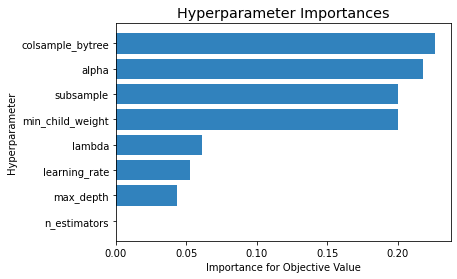

In [77]:
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(study);

In [ ]:
"""
from sklearn.model_selection import GridSearchCV
params = {
        'min_child_weight': [1, 5, 10],D
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6, 10],
        'n_estimators': [100, 300, 500]
        }
model = xg.XGBRegressor()
xgb_grid = GridSearchCV(model,
                        params,
                        scoring='neg_mean_squared_log_error',
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

"""

Важность признаков

In [78]:
from sklearn.inspection import permutation_importance

In [82]:
r = permutation_importance(model, X_test, y_test, n_repeats=5)

In [83]:
perm_df = pd.DataFrame((r['importances_mean'], X_train.columns.to_list()), index=('Score', 'Features'))
perm_df = perm_df.T
perm_df = perm_df.sort_values(ascending=False, by='Score')

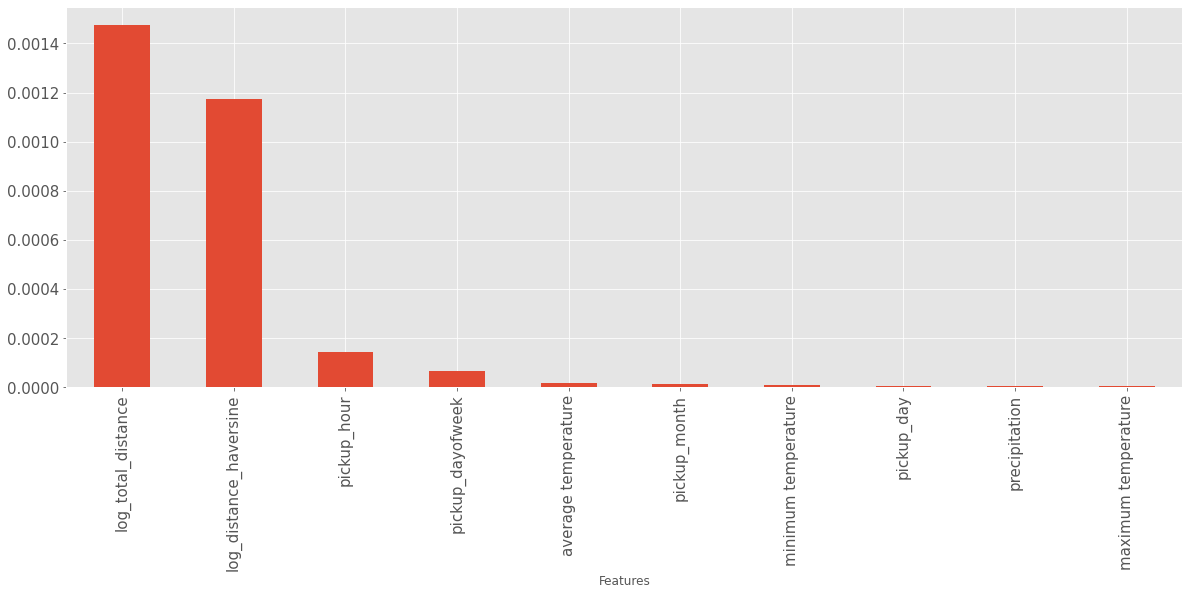

In [84]:
perm_df[:10].set_index('Features')['Score'].plot.bar(figsize=(20, 7), grid=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()